## Experiments on CIFAR-100

In [1]:
import os
import tensorflow as tf
import numpy as np
from mlp.data_providers import CIFAR10DataProvider, CIFAR100DataProvider
import matplotlib.pyplot as plt
import time

### CIFAR-100

In [2]:
random_seed = 142857
rng = np.random.RandomState(random_seed)
train_data = CIFAR10DataProvider('train', batch_size=50,rng=rng)
valid_data = CIFAR10DataProvider('valid', batch_size=50,rng=rng)

### EXPERIMENT 1 - CNN

In [3]:
def data_augmentation(image, theight, twidth, whitten_image = True):
    # augmentation by croping the images target_height = 36, target_width = 36
    # padding_image = tf.image.resize_image_with_crop_or_pad(image, 36, 36)
    flip_image = tf.map_fn(lambda img: tf.image.random_flip_left_right(img), image)
    if whitten_image:
        whitten_image = tf.map_fn(lambda img: tf.image.per_image_standardization(img), flip_image)
        return whitten_image
    else:
        return flip_image
    # flip_image = tf.image.random_flip_left_right(image)
    # new_image = tf.image.resize_image_with_crop_or_pad(flip_image, theight, twidth)    

In [4]:
def kernel(name, shape, stddev, wd=None):
    dtype = tf.float32
    with tf.device('/cpu:0'):
        kernel_weights = tf.get_variable(name,shape,initializer=tf.contrib.layers.xavier_initializer_conv2d())
    if wd is not None:
        weight_decay = tf.multiply(tf.nn.l2_loss(kernel_weights), wd, name='weight_loss')
        kernel_weights = tf.add(kernel_weights,weight_decay)
    return kernel_weights
    

In [5]:
def cnn_layer(inputs,kernel,strides,output_channel,nonlinearity=tf.nn.relu,dropout=False,keep_prob=1.0):
    conv = tf.nn.conv2d(inputs, kernel, strides, padding='SAME')
    biases = tf.Variable(tf.zeros([output_channel]),'biases')
    pre_activation = tf.nn.bias_add(conv, biases)
    if dropout:
        outputs = tf.nn.dropout(nonlinearity(pre_activation), keep_prob)
    else:
        outputs = nonlinearity(pre_activation)
    return outputs

In [6]:
def BN_layer(inputs, input_dim, phase_train, scope='bn'):
    with tf.variable_scope(scope):
        beta = tf.Variable(tf.constant(0.0,shape=input_dim),name='beta',trainable=True)
        gamma = tf.Variable(tf.constant(1.0,shape=input_dim),name='gamma',trainable=True)
        
        batch_mean, batch_var = tf.nn.moments(inputs, [0], name='moments')
        
        ema = tf.train.ExponentialMovingAverage(decay=0.5)
        def mean_var_with_update():
            ema_apply_op = ema.apply([batch_mean, batch_var])
            with tf.control_dependencies([ema_apply_op]):
                return tf.identity(batch_mean), tf.identity(batch_var)

        mean, var = tf.cond(phase_train,
                            mean_var_with_update,
                            lambda: (ema.average(batch_mean), ema.average(batch_var)))
        normed = tf.nn.batch_normalization(inputs, mean, var, beta, gamma, 1e-3)
    return normed

In [7]:
def fully_connected_layer(inputs, input_dim, output_dim, nonlinearity=tf.nn.relu,dropout=False,keep_prob=1.0, wd=None):
    with tf.device('/cpu:0'):
        weights = tf.Variable(
            tf.truncated_normal(
                [input_dim, output_dim], stddev=2. / (input_dim + output_dim)**0.5), 
            'weights')
        biases = tf.Variable(tf.zeros([output_dim]), 'biases')
    
    if wd is not None:
        weight_decay = tf.multiply(tf.nn.l2_loss(weights), wd, name='weight_loss')
        weights = tf.add(weights,weight_decay)    
    if dropout:
        outputs = tf.nn.dropout(nonlinearity(tf.matmul(inputs, weights) + biases), keep_prob)
    else:
        outputs = nonlinearity(tf.matmul(inputs, weights) + biases)  
    
    return outputs

In [8]:
def max_pooling_layer(inputs, window_size, strides):
    # using max pooling
    pooling_output = tf.nn.max_pool(inputs, ksize=window_size, strides=strides, padding='SAME')
    return pooling_output

In [9]:
def avg_pooling_layer(inputs, window_size, strides):
    # using global average pooling
    pooling_output = tf.nn.avg_pool(inputs, ksize=window_size, strides=strides, padding='VALID')
    return pooling_output

In [14]:
def residual_layer(inputs, previous_inputs,
                   kernel,strides,output_channel,nonlinearity=tf.nn.relu,dropout=False,keep_prob=1.0):
    conv = tf.nn.conv2d(inputs, kernel, strides, padding='SAME')
    biases = tf.Variable(tf.zeros([output_channel]),'biases')
    pre_activation = tf.nn.bias_add(conv+previous_inputs, biases)
    if dropout:
        outputs = tf.nn.dropout(nonlinearity(pre_activation), keep_prob)
    else:
        outputs = nonlinearity(pre_activation)
    return outputs
    

In [16]:
tf.reset_default_graph()

inputs = tf.placeholder(tf.float32, [None,train_data.inputs.shape[1]], 'inputs')
targets = tf.placeholder(tf.float32, [None,train_data.num_classes], 'targets')

# for setting dropout 
keep_prob = tf.placeholder(tf.float32)

# for setting batch normalization
phrase_train = tf.placeholder(tf.bool,name='phase_train')

# learning rate schedule manually
learning_rate = tf.placeholder(tf.float32)

with tf.name_scope('data_augmentation'):
    reshape_inputs = tf.reshape(inputs,[50,32,32,3])
    aug_inputs = data_augmentation(reshape_inputs, 32, 32)

with tf.name_scope('kernel-1'):
    kernel_1 = kernel('kernel-1', [5,5,3,64], stddev=5e-2, wd=0.0001)
with tf.name_scope('cnn-layer-1'):    
    cnn_1 = cnn_layer(aug_inputs, kernel_1, [1,1,1,1],64,dropout=False, keep_prob=keep_prob)  
with tf.name_scope('bn-layer-1'):
    bn_1 = BN_layer(cnn_1, [32,32,64], phrase_train)
    
with tf.name_scope('kernel-2'):
     kernel_2 = kernel('kernel-2', [5,5,64,64], stddev=5e-2, wd=0.0001)
with tf.name_scope('cnn-layer-2'):    
    cnn_2 = cnn_layer(bn_1, kernel_2, [1,1,1,1],64,dropout=False, keep_prob=keep_prob)  
with tf.name_scope('bn-layer-2'):
    bn_2 = BN_layer(cnn_2, [32,32,64], phrase_train)

# residual layer
with tf.name_scope('kernel-3'):
    kernel_3 = kernel('kernel-3',[5,5,64,64], stddev = 5e-2, wd=0.0001)
with tf.name_scope('residual_layer-1'):
    res_1 = residual_layer(bn_2,bn_1,kernel_3,[1,1,1,1],64,dropout=False, keep_prob=keep_prob)
with tf.name_scope('bn-layer-3'):
    bn_3 = BN_layer(res_1,[32,32,64],phrase_train)   
    
with tf.name_scope('avg_pooling'):
    avg_pool = avg_pooling_layer(bn_3, window_size=[1, 2, 2, 1], strides=[1, 1, 1, 1])
    
with tf.name_scope('hidden-layer-1'):
    out_of_cnn = tf.reshape(avg_pool,[50,-1])
    hidden_1 = fully_connected_layer(out_of_cnn, 61504, 1024, dropout=True, keep_prob=keep_prob)   
with tf.name_scope('hidden-layer-2'):
    hidden_2 = fully_connected_layer(hidden_1, 1024, 1024, dropout=True, keep_prob=keep_prob)
with tf.name_scope('output-layer'):
    outputs = fully_connected_layer(hidden_2, 1024, train_data.num_classes, tf.identity)

with tf.name_scope('error'):
    error = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
            tf.float32))
with tf.name_scope('train'):
    train_step = tf.train.MomentumOptimizer(learning_rate = learning_rate,momentum=0.9).minimize(error)
    
init = tf.global_variables_initializer()

In [17]:
train_log = {'epoch_num':[],
             'running_error':[],
             'running_accuracy':[],
             'running_time':[]
            }
valid_log = {'epoch_num':[],
             'running_error':[],
             'running_accuracy':[],
            }
train_data.reset()
valid_data.reset()

with tf.Session() as sess:
    sess.run(init,feed_dict={phrase_train: True, learning_rate: 0.01})
    for e in range(50):
        running_error = 0.
        running_accuracy = 0.
        start_time = time.time()
        if e <= 15: lr = 0.001
        elif e <= 30: lr = 0.0001
        elif e <= 40: lr = 0.00001
        else: lr = 0.000001
        for input_batch, target_batch in train_data:
            _, batch_error, batch_acc = sess.run(
                [train_step, error, accuracy], 
                feed_dict={inputs: input_batch, targets: target_batch, keep_prob:0.8, phrase_train: True, learning_rate:lr})
            running_error += batch_error
            running_accuracy += batch_acc
        epoch_time = time.time() - start_time
        running_error /= train_data.num_batches
        running_accuracy /= train_data.num_batches
        train_log['epoch_num'].append(e+1)
        train_log['running_error'].append(running_error)
        train_log['running_accuracy'].append(running_accuracy)
        train_log['running_time'].append(epoch_time)
        print('End of epoch {0:02d}: err(train)= {1:.2f} acc(train)= {2:.2f} time(train)= {3:.2f}'
              .format(e + 1, running_error, running_accuracy, epoch_time))
        if (e + 1) % 1 == 0:
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch, keep_prob:1.0, phrase_train: False})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            valid_log['epoch_num'].append(e+1)
            valid_log['running_error'].append(valid_error)
            valid_log['running_accuracy'].append(valid_accuracy)
            print('                 err(valid)= {0:.2f} acc(valid)= {1:.2f}'
                   .format(valid_error, valid_accuracy))

End of epoch 01: err(train)= 1.84 acc(train)= 0.41 time(train)= 1393.25
                 err(valid)= 1.33 acc(valid)= 0.53


KeyboardInterrupt: 

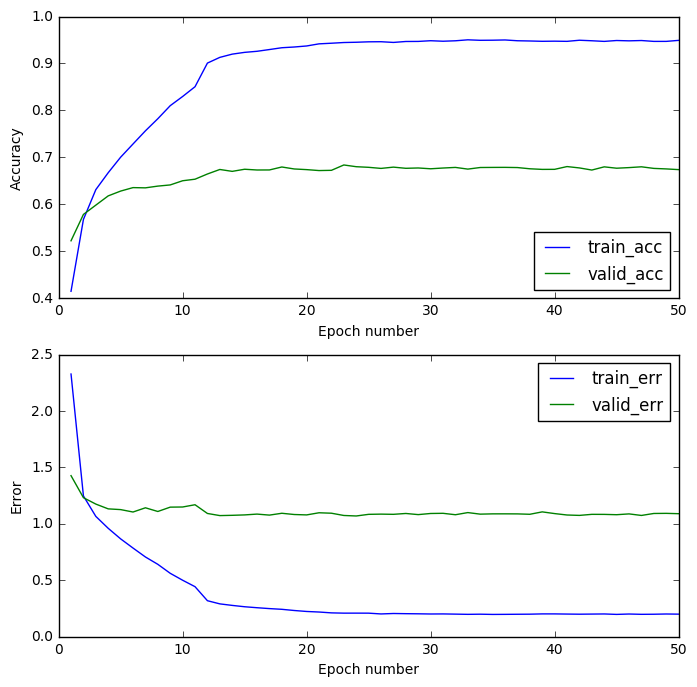

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

#print train_log

fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.plot(train_log['epoch_num'],train_log['running_accuracy'],label='train_acc')
ax1.plot(valid_log['epoch_num'],valid_log['running_accuracy'],label='valid_acc')
ax2.plot(train_log['epoch_num'],train_log['running_error'],label='train_err')
ax2.plot(valid_log['epoch_num'],valid_log['running_error'],label='valid_err')

ax1.legend(loc=0)
ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Accuracy')
ax2.legend(loc=0)
ax2.set_xlabel('Epoch number')
ax2.set_ylabel('Error')

plt.show()

In [27]:
import sys
import os

f = open("exp_result_3-64-64cnn",'w')
#print train_log

for item in range(len(train_log['running_accuracy'])):
    #print item
    f.write("epoch: {0} train_acc: {1:.2f} train_err: {2:.2f} time: {3:.2f} \n".format(train_log['epoch_num'][item],
                                                                                       train_log['running_accuracy'][item],
                                                                                       train_log['running_error'][item],
                                                                                       train_log['running_time'][item]))
    f.write("valid_epoch: {0} valid_acc: {1:.2f} valid_err: {2:.2f} \n".format(valid_log['epoch_num'][item],
                                                                                       valid_log['running_accuracy'][item],
                                                                                       valid_log['running_error'][item]))